In [1]:
import geopandas as gpd
import pandas as pd
import requests
from dep_tools.grids import PACIFIC_EPSG
from fiona.io import ZipMemoryFile
from odc.geo.geom import Geometry
from odc.geo.xr import mask
from odc.stac import load
from pystac.client import Client
from xarray import DataArray, Dataset

In [2]:
country = "png"
code = "PNG"
short = "png"

In [3]:
# First get the country EEZs
url = "https://files.auspatious.com/unsw/EEZ_land_union_v4_202410.zip"
source_internal_path_name = "EEZ_land_union_v4_202410/EEZ_land_union_v4_202410.shp"
zip_bytes = requests.get(url).content

with ZipMemoryFile(zip_bytes) as z:
    with z.open(source_internal_path_name) as src:
        eez = gpd.GeoDataFrame.from_features(src, crs=src.crs)

In [4]:
# eez.explore()

In [5]:
# Only do png
eez_png = eez[eez["ISO_SOV1"] == "PNG"].to_crs("EPSG:4326")

# Convert to ODC Geometry
eez_png_geom = Geometry(eez_png.geometry.values[0], crs=eez_png.crs)
# eez_png.explore()

In [6]:
# Get some seagrass data for the area
client = Client.open("https://stac.digitalearthpacific.org")
items = client.search(
    collections=["dep_s2_ammi"],
    intersects=eez_png_geom.json
).item_collection()

print(f"Found {len(items)} items")



Found 1176 items


### 10% canopy cover threshold 

#### Mangroves_processor in staging converted to 10% canopy cover

Land spanning more than 0.5 hectares with trees higher than 5 meters and a canopy cover of more than 10 percent, or trees able to reach these thresholds in situ. It does not include land that is predominantly under agricultural or urban land use. 

In [7]:
data = load(
    items,
    bands=["mangroves"],
    crs=PACIFIC_EPSG,  # 
    resolution=100,  # Change to 10 for full resolution,
    chunks={"x": 2048, "y": 2048}
)

# Convert data to 0 and 1, where 

data = data.mangroves != 255

data

<xarray.DataArray 'mangroves' (time: 8, y: 12480, x: 22080)> Size: 2GB
dask.array<ne, shape=(8, 12480, 22080), dtype=bool, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 100kB -6.405e+04 -6.415e+04 ... -1.312e+06
  * x            (x) float64 177kB -1.08e+06 -1.08e+06 ... 1.128e+06 1.128e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01

In [8]:
def xarray_calculate_area(
    data: Dataset | DataArray,
    geom: Geometry,
    variable: str | None = None,
    value: int | float | None = None,
) -> float:
    # Work with a dataarray, not a dataset, so it's a singular thing
    if type(data) is not DataArray:
        if variable is None:
            raise ValueError("Variable must be specified when data is a Dataset.")
        data = data[variable]

    # Only select a specific value. This will convert to float, with nans
    if value is not None:
        data = data.where(data == value)

    # Mask out regions outsize the geometry
    masked = mask(data, geom.to_crs(data.odc.crs))

    # Count all the non-nan cells, and multiply by area
    count = float(masked.notnull().sum().values)
    one_pixel_area = abs(
        masked.odc.geobox.resolution.x * masked.odc.geobox.resolution.y
    )

    return float(count) * one_pixel_area

In [9]:
data

<xarray.DataArray 'mangroves' (time: 8, y: 12480, x: 22080)> Size: 2GB
dask.array<ne, shape=(8, 12480, 22080), dtype=bool, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 100kB -6.405e+04 -6.415e+04 ... -1.312e+06
  * x            (x) float64 177kB -1.08e+06 -1.08e+06 ... 1.128e+06 1.128e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01

In [10]:
# Run the xarray_calculate_area per time step
results = []
for time in data.time:
    da = data.sel(time=time)
    area_m2 = xarray_calculate_area(da, eez_png_geom, variable="mangroves", value=1)
    # Year, in YYYY, area in m2, area in km2
    results.append({
        "time": pd.to_datetime(time.values).year,
        "area_m2": area_m2,
        "area_km2": area_m2 / 1e6
    })

df = pd.DataFrame(results)
df

/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


,time,area_m2,area_km2
0,2017,3.647180e+09,3647.18
1,2018,3.922190e+09,3922.19
2,2019,3.428460e+09,3428.46
3,2020,3.591460e+09,3591.46
4,2021,3.936630e+09,3936.63
5,2022,4.526880e+09,4526.88
6,2023,4.600310e+09,4600.31
7,2024,4.772910e+09,4772.91


<Axes: title={'center': 'png Mangrove Area Over Time'}, xlabel='time'>

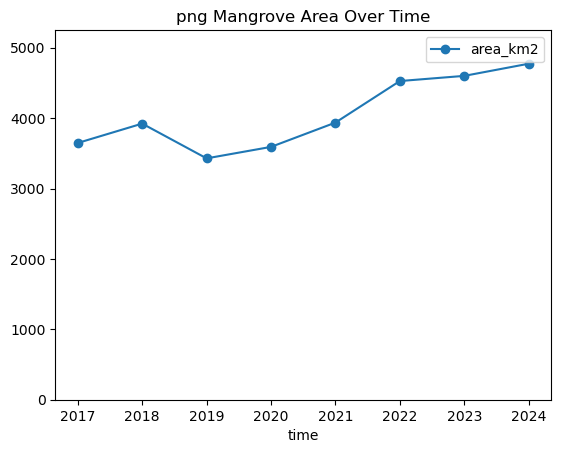

In [11]:
df.plot(x="time", y="area_km2", marker="o", title="png Mangrove Area Over Time", ylim=(0, df["area_km2"].max() * 1.1))

In [12]:
for r in results:
    print(f"{r['time']}: {r['area_km2']:.2f} km²")

2017: 3647.18 km²
2018: 3922.19 km²
2019: 3428.46 km²
2020: 3591.46 km²
2021: 3936.63 km²
2022: 4526.88 km²
2023: 4600.31 km²
2024: 4772.91 km²


In [13]:
df.to_csv("png_ammi_changeseries.csv")

In [14]:
mangroves_2018 = data.isel(time=1)
mangroves_2018 = mangroves_2018.astype("uint16")
mangroves_2018.odc.write_cog("mangroves_ammi_2018.tiff")

PosixPath('mangroves_ammi_2018.tiff')

In [15]:
mangroves_2024 = data.isel(time=7)
mangroves_2024 = mangroves_2024.astype("uint16")
mangroves_2024.odc.write_cog("mangroves_ammi_2024.tiff")

PosixPath('mangroves_ammi_2024.tiff')

In [16]:
mangrove_change_2018_2024 = (mangroves_2024*-2) - mangroves_2018

In [17]:
mangrove_change_2018_2024.odc.write_cog("mangroves_ammi_change_2018_2024.tiff")

PosixPath('mangroves_ammi_change_2018_2024.tiff')